In [20]:
import numpy as np
import scipy.io as sio
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import urllib.request
from keras.datasets import mnist

import matplotlib.pyplot as plt

import warnings
from datetime import datetime

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

import os
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns

# suppress warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Choose light or full version to run the notebook:
- Light will use small values of parameters for MNIST (number of neurons, number of iterations, ...)
- Full will use the values used in the report of this project

In [2]:
notebook_version='light' # 'light' or 'full'
# notebook_version='full' # 'light' or 'full'

## 1.1. Data

This section defines functions to load the 2 datasets and prepare them for analysis

In [3]:
def telecharger_alpha_digit(directory='data/'):
    """ Téléchargement des données de l'archive Binary Alpha Digits
    à partir de https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat
    """
    
    # Création du répertoire de stockage de dataset
    if not os.path.exists(directory):
        os.makedirs(directory)
    # Téléchargement du fichier dans le répertoire choisi
    url = "https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat"
    urllib.request.urlretrieve(url, directory + "binaryalphadigs.mat")

def lire_alpha_digit(chars):
    telecharger_alpha_digit()
    alpha_digits = sio.loadmat("data/binaryalphadigs.mat", squeeze_me=True)["dat"]

    arr = []
    y = []
    for i, char in enumerate(chars):
        if type(char) == int:
            char = str(char)

        asc_char = ord(char)
        if asc_char >= 65 and asc_char <= 90:
            for digit in alpha_digits[asc_char - 55]:
                arr.append(digit.flatten())
                y.append(asc_char - 55)
        elif asc_char >= 48 and asc_char <= 57:
            for digit in alpha_digits[asc_char - 48]:
                arr.append(digit.flatten())
                y.append(asc_char - 48)
        else:
            raise Exception("Char not valid")
    return np.array(arr), np.array(y)

def one_hot(y):
    unique_labels = np.unique(y)
    y_ohe = np.zeros((y.shape[0], len(unique_labels)))
    for i in range(y.shape[0]):
        y_ohe[i, np.where(unique_labels == y[i])] = 1
    return y_ohe

def lire_mnist(subsample_size=-1):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # subsample
    if subsample_size != -1:
        X_train = X_train[:subsample_size]
        y_train = y_train[:subsample_size]

    # to binary and flatten
    X_train_bin = (X_train >= 128).astype(int).reshape(X_train.shape[0], -1)
    X_test_bin = (X_test >= 128).astype(int).reshape(X_test.shape[0], -1)

    # enc = OneHotEncoder(handle_unknown='ignore')
    # # enc.fit(y_train.reshape(-1, 1))
    # y_train = enc.fit_transform(y_train.reshape(-1, 1)).todense()
    # y_test = enc.fit_transform(y_test.reshape(-1, 1)).todense()
    y_train = one_hot(y_train)
    y_test = one_hot(y_test)

    return X_train_bin, X_test_bin, y_train, y_test

def char(idx):
    if 0 <= idx <= 9:
        return chr(idx + 48)
    else:
        return chr(idx + 55)

## 1.2. Functions

Standard functions to be used over the notebook

In [4]:
def softmax(x):
    """
    Calcule la fonction softmax.
    """
    return (np.exp(x).T / np.sum(np.exp(x), axis=1)).T


def sigmoid(x):
    """
    Calcule la fonction sigmoïde.
    """
    return 1 / (1 + np.exp(-x))


def calcul_softmax(layer, X):
    """
    Calcule les probabilités sur les unités de sortie à partir de la fonction softmax. Cette fonction retournera les probabilités sur les unités de sortie et prendra en argument un RBM et des données d'entrée.
    """
    return softmax(np.dot(X, layer.W) + layer.b)

def err_rate(acc_list):
    """ Calcule une liste de taux d'erreur avec la liste d'accuracy score en entrée """
    return [1-acc for acc in acc_list]

## 1.3. Plot functions
Specific functions to plot results and save in .png files

In [5]:
# Create directory to save plots
savepath = 'save/'
if not os.path.exists(savepath):
    os.makedirs(savepath)
    print('Directory "' + str(savepath) + '" created')

In [37]:
def plot_data(X, y=None, save=False):
    perm = np.random.permutation(X.shape[0])
    plt.figure()
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(1-X[perm[i]], cmap="gray")
        if y is not None:
            plt.xlabel(char(y[perm[i]]))
    plt.tight_layout()
    if save:
        plt.savefig(f"{savepath + save}.png")
    plt.show()


def plot_batched_images(batched_images, variables, save=False):
    plt.figure(figsize=(len(batched_images) * 1.5, len(variables) * 1.5))
    for i, images in enumerate(batched_images):
        for j, img in enumerate(images):
            plt.subplot(len(images), len(batched_images), i + 1 + j * len(variables))
            plt.imshow(1-img, cmap="gray")
            if j == 0:
                plt.title(f"{variables[i]}")
            plt.axis("off")
    plt.tight_layout()
    if save:
        plt.savefig(f"{savepath + save}.png")
    plt.show()


def plot_preds(X, y_true, y_pred, save=False):
    num_cols = 2
    num_rows = 3

    # random permutation on test set
    perm = np.random.permutation(len(y_true))

    plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
    for i in range(num_rows * num_cols):
        idx = perm[i]
        true_label = np.argmax(y_true[idx])
        predictions_array = y_pred[idx]
        predicted_label = np.argmax(predictions_array)

        if true_label == predicted_label:
            color = "green"
        else:
            color = "red"

        # image
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(1-X[idx].reshape(28, 28), cmap=plt.cm.gray)
        plt.xlabel(
            "truth={}, pred={}".format(
                true_label,
                predicted_label,
                # 100 * np.max(predictions_array),
                # color=color,
            )
        )

        # probs
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        bp = plt.bar(range(10), predictions_array, color="#777777")
        bp[predicted_label].set_color("red")
        bp[true_label].set_color("green")
        plt.ylim([0, 1])
        plt.xlabel(
            "score={:2.0f}".format(
                100 * np.max(predictions_array)
            )
        )

    if save:
        plt.savefig(f"{savepath + save}.png")

    plt.show()

def plot_confusion_matrix (X, y_true, y_pred, save=False):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", square=True, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix")
    if save:
        plt.savefig(f"{savepath + save}_conf_matrix.png")
    plt.show()

def plot_DNN(x_axis, acc_1, acc_2=None, acc_1_train=None, acc_2_train=None, x_label='', top=None, save=False):
    """
    Plot DNN results (for a set of values for a given parameter to be tested)
    
    Params:
    -------
    x_axis: list of values that were tested
    acc_1: list of accuracy scores on the test set (pretrain) 
    acc_2: list of accuracy scores on the test set (train only) 
    acc_1_train: list of accuracy scores on the train set (pretrain) 
    acc_2_train: list of accuracy scores on the train set (train only) 
    x_label: name of the variable that was tested
    top: top limit of y axis
    save: name of the file to save the plot (without extension), None if no 
    Returns:
    --------
    Nothing but plot the graph and if requested save it in a .png file
    """
    plt.plot(
        x_axis,
        err_rate(acc_1),
        label="Pretrain + train (test set)",
        color='blue',
        marker="o",
        markersize=8,
    )
    if acc_1_train != None:
        plt.plot(
            x_axis,
            err_rate(acc_1_train),
            label="Pretrain + train (train set)",
            color='blue',
            linestyle='dashed', 
            linewidth=.5
        )
    if acc_2 != None:
        plt.plot(
            x_axis,
            err_rate(acc_2),
            label="Train only (test set)",
            color='orange',
            marker="o",
            markersize=8
        )
    if acc_2_train != None:
        plt.plot(
            x_axis,
            err_rate(acc_2_train),
            label="Train only (train set)",
            color='orange',
            linestyle='dashed',
            linewidth=.5    
        )
    plt.xticks(x_axis)
    plt.gca().set_ylim(bottom=0)
    if top!=None:
        plt.gca().set_ylim(top=top)
    plt.xlabel(x_label)
    plt.ylabel("Error rate")
    plt.legend()
    if save:
        plt.savefig(savepath + save + ".png")
    plt.show()

# 2. Models

## 2.1. RBM (Restricted Boltzmann Machine)

In [7]:
class RBM:
    def __init__(self, p, q):
        """
        Construit et initialise les poids et les biais d'un RBM. Cette fonction retournera une structure RBM avec des poids et biais initialisés.
        On initialisera les biais à 0 tandis que les poids seront initialisés aléatoirement suivant une loi normale centrée, de variance égale à 0.01.
        """
        self.W = np.random.normal(0, 0.01, (p, q))
        self.a = np.zeros(p)
        self.b = np.zeros(q)

    def entree_sortie(self, X):
        """
        Calcule la valeur des unités de sortie d'un RBM à partir des données d'entrée et de la fonction sigmoïde.
        """
        return sigmoid(np.dot(X, self.W) + self.b)

    def sortie_entree(self, H):
        """
        Calcule la valeur des unités d'entrée d'un RBM à partir des données de sortie et de la fonction sigmoïde.
        """
        return sigmoid(np.dot(H, self.W.T) + self.a)

    def train(self, X, epochs, lr, batch_size):
        """
        Apprend un RBM par l'algorithme Contrastive-Divergence-1. Cette fonction retournera un structure
        RBM et prendra en argument une structure RBM, le nombre d'itérations de la descente de gradient (epochs),
        le learning rate, la taille du mini-batch, des données d'entrées...
        """
        print("Entrainement du RBM...")
        n = X.shape[0]
        p, q = self.W.shape
        for epoch in tqdm(range(epochs)):
            X_copy = np.copy(X)
            np.random.shuffle(X_copy)
            for i in range(0, n, batch_size):
                v_0 = X[i : i + batch_size]
                tb = len(v_0)
                es_v_0 = self.entree_sortie(v_0)
                h_0 = (np.random.uniform(size=(tb, q)) < es_v_0).astype("float")
                v_1 = (
                    np.random.uniform(size=(tb, p)) < self.sortie_entree(h_0)
                ).astype("float")
                h_1 = self.entree_sortie(v_1)
                self.W += lr / tb * (np.dot(v_0.T, es_v_0) - np.dot(v_1.T, h_1))
                self.a += lr / tb * np.sum(v_0 - v_1, axis=0)
                self.b += lr / tb * np.sum(es_v_0 - h_1, axis=0)
        # return self

    def generer_image(self, n_iter, n_image):
        """
        Génère des échantillons suivant un RBM. Cette fonction retournera et affichera les images générées et prendra en argument une structure de type RBM, le nombre d'itérations à utiliser dans l'échantillonneur de Gibbs et le nombre d'images à générer.
        """
        # p, q = self.W.shape
        # # proba = np.random.random()
        # proba = .5
        # X = (np.random.uniform(size=(n_image, p)) < proba).astype("float")
        # for i in range(n_iter):
        #     H = (np.random.uniform(size=(n_image, q)) < self.entree_sortie(X)).astype(
        #         "float"
        #     )
        #     X = (np.random.uniform(size=(n_image, p)) < self.sortie_entree(H)).astype(
        #         "float"
        #     )

        p, q = self.W.shape
        
        V = (np.random.uniform(size=(n_image, p)) < .5).astype("float")
        for i in range(n_iter):
            H = (np.random.uniform(size=(n_image, q)) < self.entree_sortie(V)).astype(
                "float"
            )
            V = (np.random.uniform(size=(n_image, p)) < self.sortie_entree(H)).astype(
                "float"
            )

        return V

## 2.2. DBN (Deep Belief Network)

In [8]:
class DBN:
    def __init__(self, n_layers):
        """
        Construit et initialise les poids et les biais d'un DBN. Cette fonction retournera un DBN avec des poids et biais initialisés.
        On initialisera les biais à 0 tandis que les poids seront initialisés aléatoirement suivant une loi normale centrée, de variance égale à 0.01.
        """
        self.layers = []
        for i in range(len(n_layers) - 1):
            self.layers.append(RBM(n_layers[i], n_layers[i + 1]))

    def __len__(self):
        return len(self.layers)

    def __getitem__(self, i):
        return self.layers[i]

    def __setitem__(self, i, layer):
        self.layers[i] = layer

    def train(self, X_init, epochs, lr, batch_size):
        """
        Apprend un DBN par la méthode Greedy Layer-Wise. Cette fonction retournera un DBN pré-entrainé et prendra en argument un DBN, le nombre d'itérations de la descente de gradient, le learning rate, la taille du mini-batch, des données d'entrées.
        """
        print("Entrainement du DBN...")
        X = X_init
        for rbm in self.layers: # pk c'était pas ça avant ? A voir
            rbm.train(X, epochs, lr, batch_size)
            X = rbm.entree_sortie(X)

    def generer_image(self, n_iter, n_image):
        """
        Génère des échantillons suivant un DBN. Cette fonction retournera et affichera les images générées et prendra en argument un DBN pré-entrainé, le nombre d'itérations à utiliser dans l'échantillonneur de Gibbs et le nombre d'images à générer.
        """
        # X = self.layers[-1].generer_image(n_iter, n_image)
        # for i in range(len(self.layers) - 2, -1, -1):
        #     p, q = self.layers[i].W.shape
        #     X = (
        #         np.random.uniform(size=(n_image, p)) < self.layers[i].sortie_entree(X)
        #     ).astype("float")
        
        p, q = self.layers[0].W.shape

        V = (np.random.uniform(size=(n_image, p)) < .5).astype("float")
        for i in range(n_iter):
            H = V.copy()
            for layer in self.layers:
                p, q = layer.W.shape
                H = (np.random.uniform(size=(n_image, q)) < layer.entree_sortie(H)).astype(
                    "float"
                )
            V = H.copy()
            for layer in self.layers[::-1]:
                p, q = layer.W.shape
                V = (np.random.uniform(size=(n_image, p)) < layer.sortie_entree(V)).astype(
                    "float"
                )
        
        return V

## 2.3. DNN (Deep Neural Network)

In [9]:
class FC:
    def __init__(self, p, q):
        self.W = np.random.normal(0, 0.1, (p, q))
        self.b = np.zeros(q)


class DNN(DBN):
    def __init__(self, n_layers):
        """
        Construit et initialise les poids et les biais d'un DNN. Cette fonction retournera un DNN avec des poids et biais initialisés.
        On initialisera les biais à 0 tandis que les poids seront initialisés aléatoirement suivant une loi normale centrée, de variance égale à 0.01.
        """
        self.layers = []
        for i in range(len(n_layers) - 2):
            self.layers.append(RBM(n_layers[i], n_layers[i + 1]))
        self.layers.append(FC(n_layers[-2], n_layers[-1]))

    def pretrain(self, X_init, epochs, lr, batch_size):
        """
        Pré-entraine un DNN. Cette fonction retournera un DNN pré-entrainé et prendra en argument un DNN, le nombre d'itérations de la descente de gradient, le learning rate, la taille du mini-batch, des données d'entrées.
        """
        print("Pré-entrainement du DNN...")
        X = X_init
        for rbm in self.layers[:-1]:
            rbm.train(X, epochs, lr, batch_size)
            X = rbm.entree_sortie(X)

    def entree_sortie_reseau(self, X):
        """
        Calcule les sorties sur chaque couche du réseau (couche d'entrée inclue) ainsi que les probabilités sur les unités de sortie. Cette fonction retournera une liste contenant les sorties sur chaque couche du réseau ainsi que les probabilités sur les unités de sortie et prendra en argument un DNN et des données d'entrée.
        """
        sorties = [X]
        for rbm in self.layers[:-1]:
            sorties.append(rbm.entree_sortie(sorties[-1]))
        sorties.append(calcul_softmax(self.layers[-1], sorties[-1]))
        return sorties

    def retropropagation(self, X, y, epochs, lr, batch_size, verbose):
        """
        Estime les poids/biais du réseau à partir de données labellisées. Cette fonction retournera un DNN et prendra en argument un DNN, le nombre d'itérations de la descente de gradient, le learning rate, la taille du mini-batch, des données d'entrée, leur label,...
        """
        print("Entrainement du DNN...")
        for epoch in tqdm(range(epochs)):
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i : i + batch_size]
                y_batch = y[i : i + batch_size]
                tb = len(X_batch)
                sortie = self.entree_sortie_reseau(X_batch)
                # compute dL/dZ
                d_Z = sortie[-1] - y_batch

                for j in range(len(self.layers) - 1, -1, -1):
                    grad_W = 1 / tb * np.dot(sortie[j].T, d_Z)
                    grad_b = 1 / tb * np.sum(d_Z, axis=0)

                    # update W and b
                    self.layers[j].W -= lr * grad_W
                    self.layers[j].b -= lr * grad_b

                    if j == 0:  # no need to compute at last iteration
                        break

                    # compute dL/dA and dL/dZ
                    d_A = np.dot(d_Z, self.layers[j].W.T)
                    d_Z = d_A * sortie[j] * (1 - sortie[j])
                cross_entropy = -np.mean(np.sum(y_batch * np.log(sortie[-1]), axis=1))
            if verbose == 2:
                print(f"Epoch {epoch} - CE:", cross_entropy)

    def test(self, X, y):
        """
        Teste les performances du réseau appris. Cette fonction retournera le taux d'erreur et prendra en argument un DNN appris, un jeu de données test, et les vrais labels associés.
        """
        sortie = self.entree_sortie_reseau(X)
        # Compute cross entropy
        cross_entropy = -np.mean(np.sum(y * np.log(sortie[-1]), axis=1))
        return sortie[-1], cross_entropy

## 2.4. Main functions to launch models

In [10]:
def RBM_main(
    X,
    width: int,
    height: int,
    q: int,
    epochs: int,
    lr,
    batch_size: int,
    n_images: int = 9,
):

    rbm = RBM(p=width * height, q=q)
    
    rbm.train(X, epochs, lr, batch_size)

    X_gen = rbm.generer_image(100, n_images).reshape(-1, width, height)
    return X_gen

In [11]:
def DBN_main(
    X,
    n_layers,
    width: int,
    height: int,
    epochs: int,
    lr,
    batch_size: int,
    n_images: int = 9,
):
    dbn = DBN(n_layers)

    dbn.train(X, epochs, lr, batch_size)

    X_gen = dbn.generer_image(100, n_images).reshape(-1, width, height)
    return X_gen

In [12]:
def DNN_main(
    X_train,
    X_test,
    y_train,
    y_test,
    n_layers,
    lr,
    batch_size,
    pretrain_iter,
    train_iter,
    show_preds=False,
    verbose=1,
):
    # Initialisation du DNN
    dnn = DNN(n_layers)

    # Pré-entrainement du DNN
    if pretrain_iter:
        dnn.pretrain(X_train, pretrain_iter, lr, batch_size)

    # Entrainement du DNN
    dnn.retropropagation(
        X_train, y_train, train_iter, lr, batch_size, verbose
    )

    # Test du DNN
    y_train_pred, cross_entropy_train = dnn.test(X_train, y_train)
    train_score = accuracy_score(
        np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)
    )
    # Test du DNN
    y_pred, cross_entropy = dnn.test(X_test, y_test)
    test_score = accuracy_score(
        np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)
    )

    if verbose >= 1:
        print("accuracy_score (train)", train_score)
        print("accuracy_score (test)", test_score)

    if show_preds:
        plot_preds(X_test, y_test, y_pred, save="mnist_preds_with_prob")

    return cross_entropy, test_score, train_score, dnn

# 3. Binary AlphaDigit Dataset

In [103]:
alphadigit = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)]

X, y = lire_alpha_digit(chars=alphadigit)
height = 20
width = 16

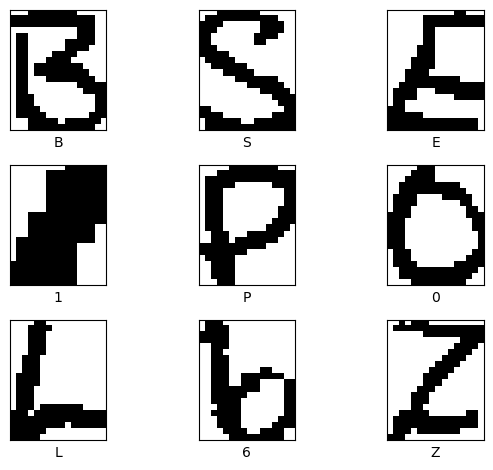

In [104]:
plot_data(X.reshape(-1, height, width), y, save="binary_alphadigit")

## 3.1. Number of neurons

We start with 2 characters and analyze the results depending on the number of neurons (100 to 700).

The first layer has 320 neurons to match the image size (20x16).

Analysis is performed for RBM and DBN (1 hidden layer)


In [155]:
digit = ['A', 'B']
# digit = [str(i) for i in range(2, 10)]
X, y = lire_alpha_digit(chars=digit)

n_neurons = range(100, 701, 200)
# n_neurons = range(100, 1001, 400)

epochs = 100
# epochs = 50

lr = 0.1
batch_size = 10

rbm_images = []
dbn_images = []

for n in n_neurons:
    print(f"--- {n} neurons by layer ---")

    X_gen_rbm = RBM_main(
        X,
        height,
        width,
        n,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_rbm.shape[0], 5, replace=False)
    rbm_images.append(X_gen_rbm[idxs])

    X_gen_dbn = DBN_main(
        X,
        [320, n, n],
        height,
        width,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_dbn.shape[0], 5, replace=False)
    dbn_images.append(X_gen_dbn[idxs])

--- 100 neurons by layer ---
Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 135.41it/s]


Entrainement du DBN...
Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 115.88it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 542.14it/s]


--- 300 neurons by layer ---
Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 104.53it/s]


Entrainement du DBN...
Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 112.08it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 104.45it/s]


--- 500 neurons by layer ---
Entrainement du RBM...


100%|██████████| 100/100 [00:03<00:00, 31.12it/s]


Entrainement du DBN...
Entrainement du RBM...


100%|██████████| 100/100 [00:02<00:00, 41.26it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:03<00:00, 29.26it/s]


--- 700 neurons by layer ---
Entrainement du RBM...


100%|██████████| 100/100 [00:02<00:00, 47.90it/s]


Entrainement du DBN...
Entrainement du RBM...


100%|██████████| 100/100 [00:02<00:00, 39.74it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


RBM


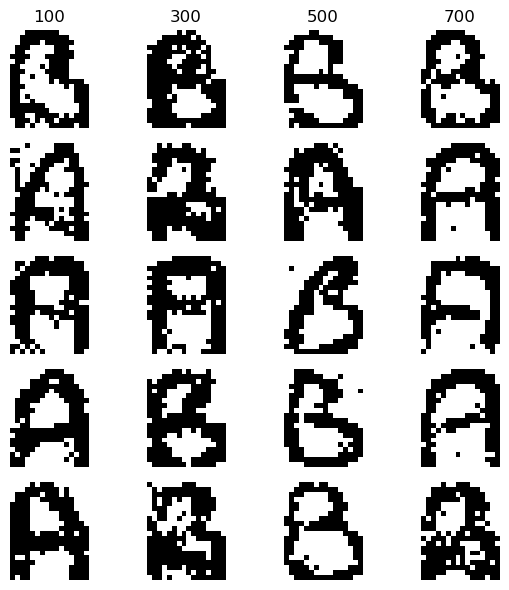

DBN


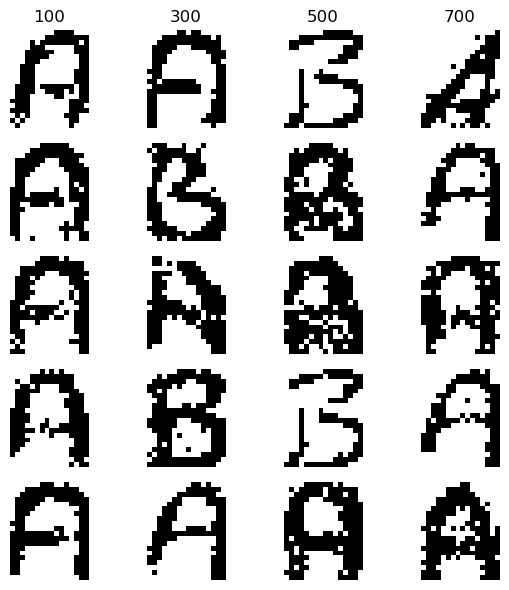

In [156]:
print("RBM")
plot_batched_images(rbm_images, n_neurons, save="rbm_n_neurons")

print("DBN")
plot_batched_images(dbn_images, n_neurons, save="dbn_n_neurons")

We are able to reproduce images as we observe in the training set

## 3.2 Number of layers

We perform the same analysis on the DBN changing the number of hidden layers.

In [151]:
digit = ['A', 'B']
X, y = lire_alpha_digit(chars=digit)

n_layers = range(1, 10, 2)

epochs = 100
lr = 0.1
batch_size = 10
q = 200

dbn_images = []

for n in n_layers:
    print(f"--- {n} layers ---")
    layers = [200] * n

    X_gen_dbn = DBN_main(
        X,
        [320] + layers,
        height,
        width,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_dbn.shape[0], 5, replace=False)
    dbn_images.append(X_gen_dbn[idxs])

--- 1 layers ---
Entrainement du DBN...
Entrainement du RBM...


100%|██████████| 100/100 [00:01<00:00, 83.70it/s]


--- 3 layers ---
Entrainement du DBN...
Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 115.36it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 160.68it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:01<00:00, 92.19it/s]


--- 5 layers ---
Entrainement du DBN...
Entrainement du RBM...


100%|██████████| 100/100 [00:01<00:00, 64.49it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:01<00:00, 96.67it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 129.81it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 162.74it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 138.88it/s]


--- 7 layers ---
Entrainement du DBN...
Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 103.16it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 173.76it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 127.19it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 144.30it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 132.76it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:01<00:00, 76.62it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:01<00:00, 94.84it/s]


--- 9 layers ---
Entrainement du DBN...
Entrainement du RBM...


100%|██████████| 100/100 [00:01<00:00, 93.99it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:01<00:00, 91.97it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 164.88it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 213.15it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 179.15it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 177.09it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 170.82it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:01<00:00, 94.20it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:00<00:00, 104.52it/s]


DBN


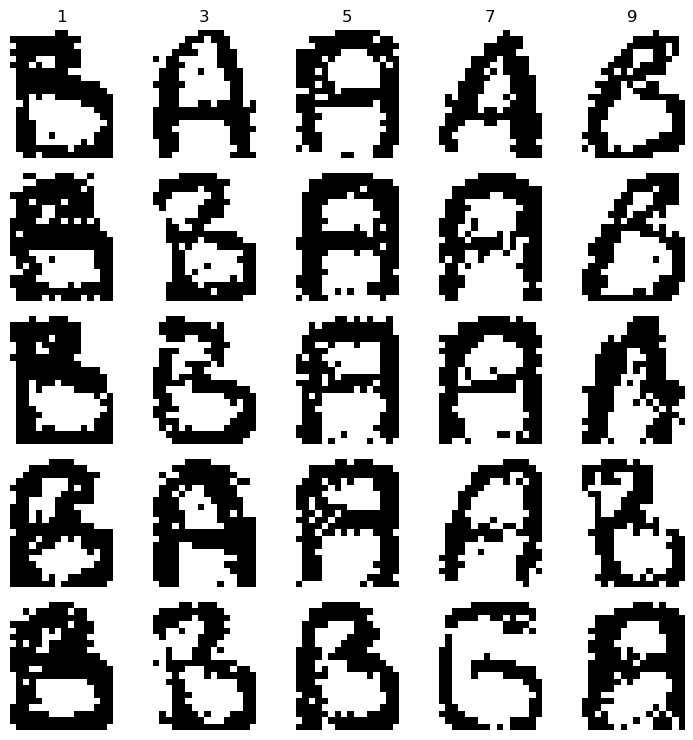

In [152]:
print("DBN")
plot_batched_images(dbn_images, n_layers, save="dbn_n_layers")

## 3.3. Richness of the training set (number of characters)

We perform the same analysis using 3 different training sets: with 2, 4 or 10 characters.

In [109]:
small = ['A', 'B']
medium = ['A', 'B', 'C', 'D']
large = [chr(i) for i in range(65, 75)]

print("Small:", small)
print("Medium:", medium)
print("Large:", large)

Small: ['A', 'B']
Medium: ['A', 'B', 'C', 'D']
Large: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


In [110]:
epochs = 100
lr = 0.1
batch_size = 10
q = 200
n_layers = [320, 200, 200]

rbm_images = []
dbn_images = []

for size, chars in zip(["small", "medium", "large"], [small, medium, large]):
    print("--- Size:", size, "---")
    X, y = lire_alpha_digit(chars=chars)

    X_gen_rbm = RBM_main(
        X,
        height,
        width,
        q,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_rbm.shape[0], 5, replace=False)
    rbm_images.append(X_gen_rbm[idxs])

    X_gen_dbn = DBN_main(
        X,
        n_layers,
        height,
        width,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_dbn.shape[0], 5, replace=False)
    dbn_images.append(X_gen_dbn[idxs])

--- Size: small ---
Entrainement du RBM...


100%|██████████| 100/100 [00:06<00:00, 14.76it/s]


Entrainement du DBN...
Entrainement du RBM...


100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:01<00:00, 90.41it/s]


--- Size: medium ---
Entrainement du RBM...


100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


Entrainement du DBN...
Entrainement du RBM...


100%|██████████| 100/100 [00:03<00:00, 29.59it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:02<00:00, 40.33it/s]


--- Size: large ---
Entrainement du RBM...


100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


Entrainement du DBN...
Entrainement du RBM...


100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


Entrainement du RBM...


100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


RBM


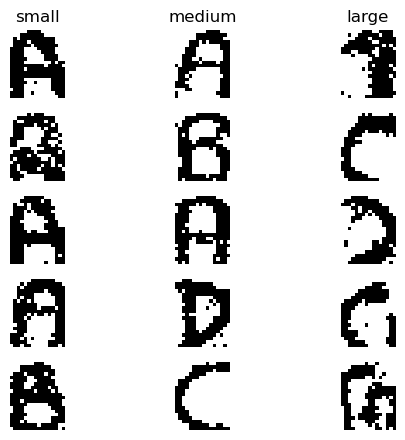

DBN


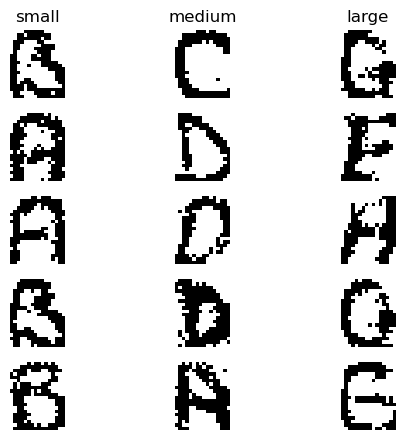

In [111]:
print("RBM")
plot_batched_images(rbm_images, ["small", "medium", "large"], save="rbm_dataset_size")

print("DBN")
plot_batched_images(dbn_images, ["small", "medium", "large"], save="dbn_dataset_size")

# 4. MNIST Dataset

This dataset is larger and we can use 60 000 training images and test it on 10 000 images.

In order to prevent very long experiments, we have 2 versions of parameter set to be used (please change it at the beginning of the notebook).

The 'full' version is the right version to launch but it can be very long to execute.

In [18]:
if notebook_version=='light':
    train_size = 12000 
    n_main = 100
    n_hidden = 2
    pretrain_iter = 10 
    train_iter = 50 
elif notebook_version=='full':
#----------
    train_size = 60000 # Default = 30000
    n_main = 200 # standard number of neurons per layer (default = 200)
    n_hidden = 2 # default = 2
    pretrain_iter = 50 # 100 default = 50?
    train_iter = 200 # 200 default = 200?

# Create directory to save plots
savepath = 'save' + '_' + str(train_size) + '_' + str(n_main) + '_' + str(n_hidden) + '_' + str(pretrain_iter) +'_' + str(train_iter) + '/'
if not os.path.exists(savepath):
    os.makedirs(savepath)
    print('Directory "' + str(savepath) + '" created')
#----------

X_train, X_test, y_train, y_test = lire_mnist(subsample_size=train_size) # -1

batch_size = 256 # 2000 
lr = 0.1

n_layers = [784] + [n_main] * n_hidden + [10]


Directory "save_12000_100_2_10_50/" created


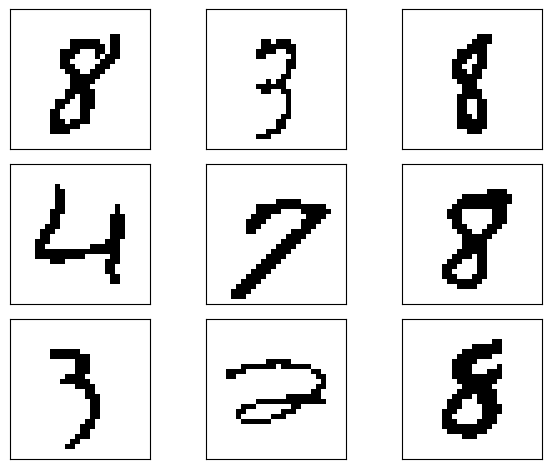

In [169]:
plot_data(X_train.reshape(-1, 28, 28), save="mnist")

## 4.1. Test the DNN

Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  7.59it/s]


Entrainement du DNN...


100%|██████████| 50/50 [00:09<00:00,  5.12it/s]


accuracy_score (train) 0.9133333333333333
accuracy_score (test) 0.9018


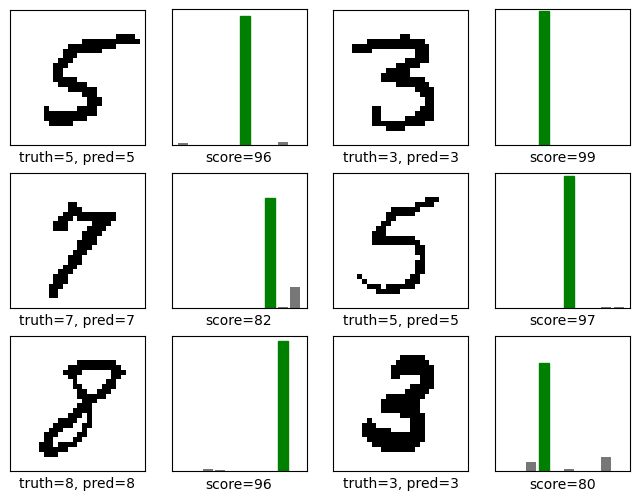

In [170]:
ce, score, train_score, _ = DNN_main(
    X_train,
    X_test,
    y_train,
    y_test,
    n_layers=[784] + [n_main] * n_hidden + [10], #--------
    # n_layers=[784] + [100] + [10], #--------
    lr=lr,
    batch_size=batch_size,
    pretrain_iter=pretrain_iter,
    train_iter=train_iter,
    show_preds=True,
    verbose=True,
)

We obtain very good results with the default parameters:
- 200 neurons per layer
- 2 layers
- complete training dataset (60 000 images)
- batch size = 256
- pretrain = 50 epochs
- train = 200 epochs

## 4.2. Number of hidden layers

In [115]:
acc_1_layer = []
acc_2_layer = []
acc_1_train_layer = []
acc_2_train_layer = []

sizes = range(1, 6)

for size in sizes:
    print(f"--- {size} hidden layer(s) ---")
    n_layers = [784] + [n_main] * size + [10]  #--------
    """-------------- Model 1 : pre-train + train -------------------"""
    ce_model1, score_model1, train_score_model1, _ = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter,
        train_iter=train_iter,
        verbose=1,
    )
    acc_1_layer.append(score_model1)
    acc_1_train_layer.append(train_score_model1)

    """-------------- Model 2 : train only ---------------------------"""
    ce_model2, score_model2, train_score_model2, _ = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter,
        verbose=1,
    )
    acc_2_layer.append(score_model2)
    acc_2_train_layer.append(train_score_model2)

--- 1 hidden layer(s) ---
Pré-entrainement du DNN...
Entrainement du RBM...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


accuracy_score (train) 0.8785
accuracy_score (test) 0.8698
Entrainement du DNN...


100%|██████████| 30/30 [00:06<00:00,  4.81it/s]


accuracy_score (train) 0.9105833333333333
accuracy_score (test) 0.8993
--- 2 hidden layer(s) ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  7.01it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:07<00:00,  3.81it/s]


accuracy_score (train) 0.83425
accuracy_score (test) 0.8219
Entrainement du DNN...


100%|██████████| 30/30 [00:07<00:00,  4.28it/s]


accuracy_score (train) 0.4915833333333333
accuracy_score (test) 0.4817
--- 3 hidden layer(s) ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  9.44it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  9.04it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


accuracy_score (train) 0.7825833333333333
accuracy_score (test) 0.7688
Entrainement du DNN...


100%|██████████| 30/30 [00:10<00:00,  2.78it/s]


accuracy_score (train) 0.11258333333333333
accuracy_score (test) 0.1135
--- 4 hidden layer(s) ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  7.09it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  7.58it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:10<00:00,  2.79it/s]


accuracy_score (train) 0.7400833333333333
accuracy_score (test) 0.7318
Entrainement du DNN...


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]


accuracy_score (train) 0.11258333333333333
accuracy_score (test) 0.1135
--- 5 hidden layer(s) ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


accuracy_score (train) 0.7221666666666666
accuracy_score (test) 0.7173
Entrainement du DNN...


100%|██████████| 30/30 [00:11<00:00,  2.54it/s]


accuracy_score (train) 0.11258333333333333
accuracy_score (test) 0.1135


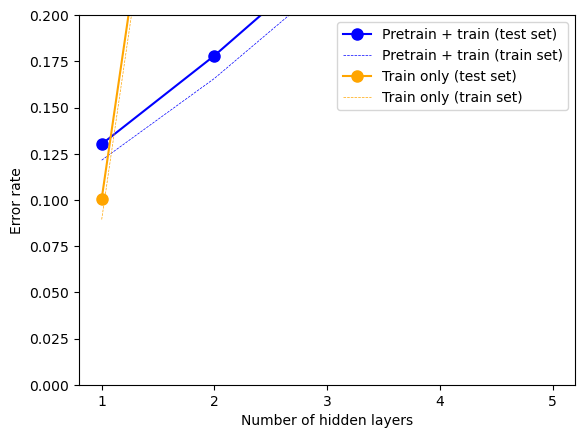

In [116]:
plot_DNN(
    sizes, 
    acc_1_layer, 
    acc_2_layer, 
    acc_1_train=acc_1_train_layer, 
    acc_2_train=acc_2_train_layer, 
    x_label='Number of hidden layers', 
    top=.2,
    save="mnist_number_hidden_layers_top"
    )

## 4.3. Number of neurons per layer

In [117]:
acc_1_neurons = []
acc_2_neurons = []
acc_1_train_neurons = []
acc_2_train_neurons = []

start = 1
stop = 6 # reduce 11
step = 1 # reduce: 2 ---------------------------------------------------------------
n_neurons = range(start * n_main, stop * n_main + 1, step * n_main)

for neurons in n_neurons:
    print(f"--- {neurons} neurons by layer, {n_hidden} layers ---")
    n_layers = [784] + [neurons] * n_hidden +  [10]
    """-------------- Model 1 : pre-train + train -------------------"""
    ce_model1, score_model1, train_score_model1, _ = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter,
        train_iter=train_iter,
        verbose=1,
    )
    acc_1_neurons.append(score_model1)
    acc_1_train_neurons.append(train_score_model1)

    """-------------- Model 2 : train only ---------------------------"""
    ce_model2, score_model2, train_score_model2, _ = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter,
        verbose=1,
    )
    acc_2_neurons.append(score_model2)
    acc_2_train_neurons.append(train_score_model2)

--- 50 neurons by layer, 2 layers ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:06<00:00,  4.50it/s]


accuracy_score (train) 0.8260833333333333
accuracy_score (test) 0.8167
Entrainement du DNN...


100%|██████████| 30/30 [00:06<00:00,  4.63it/s]


accuracy_score (train) 0.39808333333333334
accuracy_score (test) 0.3933
--- 100 neurons by layer, 2 layers ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  5.39it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:08<00:00,  3.43it/s]


accuracy_score (train) 0.8913333333333333
accuracy_score (test) 0.8839
Entrainement du DNN...


100%|██████████| 30/30 [00:08<00:00,  3.37it/s]


accuracy_score (train) 0.6955
accuracy_score (test) 0.6897
--- 150 neurons by layer, 2 layers ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


accuracy_score (train) 0.90725
accuracy_score (test) 0.9011
Entrainement du DNN...


100%|██████████| 30/30 [00:12<00:00,  2.45it/s]


accuracy_score (train) 0.7981666666666667
accuracy_score (test) 0.791
--- 200 neurons by layer, 2 layers ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Entrainement du RBM...


100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


accuracy_score (train) 0.9160833333333334
accuracy_score (test) 0.9118
Entrainement du DNN...


100%|██████████| 30/30 [00:14<00:00,  2.07it/s]


accuracy_score (train) 0.8314166666666667
accuracy_score (test) 0.82
--- 250 neurons by layer, 2 layers ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Entrainement du RBM...


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


accuracy_score (train) 0.9210833333333334
accuracy_score (test) 0.9164
Entrainement du DNN...


100%|██████████| 30/30 [00:20<00:00,  1.49it/s]


accuracy_score (train) 0.8510833333333333
accuracy_score (test) 0.8362
--- 300 neurons by layer, 2 layers ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


Entrainement du RBM...


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


accuracy_score (train) 0.9234166666666667
accuracy_score (test) 0.9194
Entrainement du DNN...


100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


accuracy_score (train) 0.8595833333333334
accuracy_score (test) 0.8424


In [118]:
len(acc_1_neurons), len(acc_2_neurons), len(acc_1_train_neurons), len(acc_2_train_neurons)

(6, 6, 6, 6)

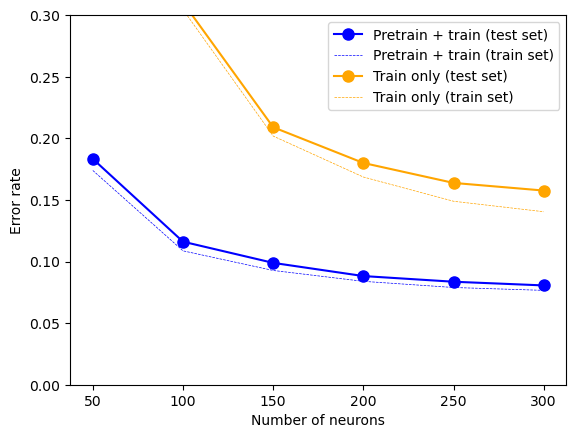

In [119]:
plot_DNN(
    n_neurons, 
    acc_1_neurons, 
    acc_2_neurons, 
    acc_1_train=acc_1_train_neurons, 
    acc_2_train=acc_2_train_neurons, 
    x_label='Number of neurons', 
    top=.3,
    save="mnist_number_of_neurons_top"
    )

## 4.4. Size of the training dataset (number of samples)

In [120]:
acc_1_train_size = []
acc_2_train_size = []
acc_1_train_size_train = []
acc_2_train_size_train = []

n_layers = [784] + [2 * n_main] * n_hidden +  [10]

samples_sizes = [2000, 6000, 12000, 30000, 60000] # ------------------------------------------
# samples_sizes = [1000, 2000, 3000, 60000, 12000, 30000, 60000]

for size in samples_sizes:
    print(f"--- {size} samples ---")
    X_train_, X_test_, y_train_, y_test_ = lire_mnist(subsample_size=size)

    """-------------- Model 1 : pre-train + train -------------------"""
    ce_model1, score_model1, train_score_model1, _ = DNN_main(
        X_train_,
        X_test_,
        y_train_,
        y_test_,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter,
        train_iter=train_iter,
        verbose=1,
    )
    acc_1_train_size.append(score_model1)
    acc_1_train_size_train.append(train_score_model1)

    """-------------- Model 2 : train only ---------------------------"""
    ce_model2, score_model2, train_score_model2, _ = DNN_main(
        X_train_,
        X_test_,
        y_train_,
        y_test_,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter,
        verbose=1,
    )
    acc_2_train_size.append(score_model2)
    acc_2_train_size_train.append(train_score_model2)

--- 2000 samples ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:00<00:00, 22.98it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:01<00:00, 16.75it/s]


accuracy_score (train) 0.5955
accuracy_score (test) 0.5737
Entrainement du DNN...


100%|██████████| 30/30 [00:01<00:00, 19.51it/s]


accuracy_score (train) 0.105
accuracy_score (test) 0.1009
--- 6000 samples ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:00<00:00, 10.36it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


accuracy_score (train) 0.83
accuracy_score (test) 0.8139
Entrainement du DNN...


100%|██████████| 30/30 [00:04<00:00,  6.55it/s]


accuracy_score (train) 0.457
accuracy_score (test) 0.4622
--- 12000 samples ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:09<00:00,  3.00it/s]


accuracy_score (train) 0.8929166666666667
accuracy_score (test) 0.8827
Entrainement du DNN...


100%|██████████| 30/30 [00:10<00:00,  2.78it/s]


accuracy_score (train) 0.7234166666666667
accuracy_score (test) 0.7193
--- 30000 samples ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


Entrainement du RBM...


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


accuracy_score (train) 0.9294
accuracy_score (test) 0.929
Entrainement du DNN...


100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


accuracy_score (train) 0.888
accuracy_score (test) 0.8839
--- 60000 samples ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:37<00:00,  3.77s/it]


Entrainement du RBM...


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:42<00:00,  1.43s/it]


accuracy_score (train) 0.94225
accuracy_score (test) 0.9406
Entrainement du DNN...


100%|██████████| 30/30 [00:42<00:00,  1.42s/it]


accuracy_score (train) 0.9252666666666667
accuracy_score (test) 0.9245


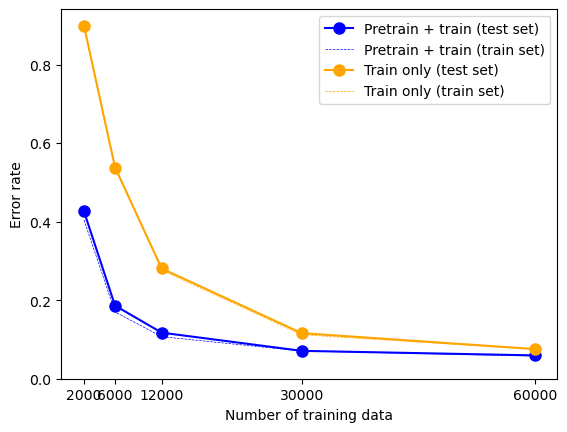

In [121]:
plot_DNN(
    samples_sizes, 
    acc_1_train_size, 
    acc_2_train_size, 
    acc_1_train=acc_1_train_size_train, 
    acc_2_train=acc_2_train_size_train, 
    x_label='Number of training data', 
    # top=.3,
    save="mnist_number_of_training_data"
    )

In [122]:
acc_1_batch_size = []
acc_2_batch_size = []
acc_1_batch_size_train = []
acc_2_batch_size_train = []

n_layers = [784] + [2 * n_main] * n_hidden +  [10]


batch_sizes = [16, 32, 64, 128, 256, 512] # ------------------------------------------
# batch_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048]

for batch_size in batch_sizes:
    print(f"--- {batch_size} samples per batch ---")

    """-------------- Model 1 : pre-train + train -------------------"""
    ce_model1, score_model1, train_score_model1, _ = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter,
        train_iter=train_iter,
        verbose=1,
    )
    acc_1_batch_size.append(score_model1)
    acc_1_batch_size_train.append(train_score_model1)

    """-------------- Model 2 : train only ---------------------------"""
    ce_model2, score_model2, train_score_model2, _ = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter,
        verbose=1,
    )
    acc_2_batch_size.append(score_model2)
    acc_2_batch_size_train.append(train_score_model2)

--- 16 samples per batch ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  9.00it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


accuracy_score (train) 0.98475
accuracy_score (test) 0.9454
Entrainement du DNN...


100%|██████████| 30/30 [00:32<00:00,  1.07s/it]


accuracy_score (train) 0.9839166666666667
accuracy_score (test) 0.9312
--- 32 samples per batch ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Entrainement du RBM...


100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


accuracy_score (train) 0.96725
accuracy_score (test) 0.9445
Entrainement du DNN...


100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


accuracy_score (train) 0.96375
accuracy_score (test) 0.9224
--- 64 samples per batch ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


accuracy_score (train) 0.9481666666666667
accuracy_score (test) 0.9335
Entrainement du DNN...


100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


accuracy_score (train) 0.9223333333333333
accuracy_score (test) 0.8952
--- 128 samples per batch ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:10<00:00,  2.76it/s]


accuracy_score (train) 0.9266666666666666
accuracy_score (test) 0.9153
Entrainement du DNN...


100%|██████████| 30/30 [00:10<00:00,  2.90it/s]


accuracy_score (train) 0.8789166666666667
accuracy_score (test) 0.8627
--- 256 samples per batch ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:08<00:00,  3.47it/s]


accuracy_score (train) 0.8905
accuracy_score (test) 0.884
Entrainement du DNN...


100%|██████████| 30/30 [00:08<00:00,  3.44it/s]


accuracy_score (train) 0.7213333333333334
accuracy_score (test) 0.7121
--- 512 samples per batch ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


Entrainement du DNN...


100%|██████████| 30/30 [00:08<00:00,  3.69it/s]


accuracy_score (train) 0.8231666666666667
accuracy_score (test) 0.8138
Entrainement du DNN...


100%|██████████| 30/30 [00:07<00:00,  3.79it/s]

accuracy_score (train) 0.3385
accuracy_score (test) 0.3361


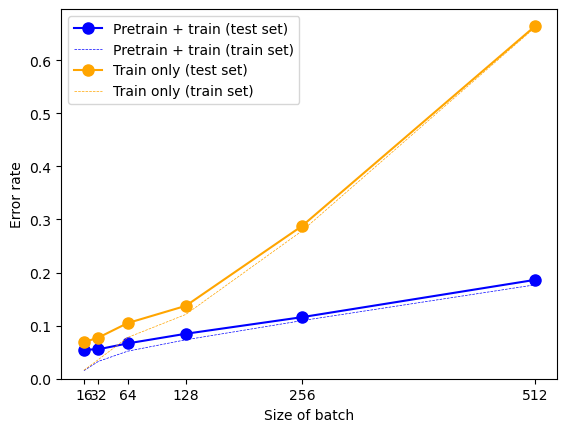

In [123]:
plot_DNN(
    batch_sizes, 
    acc_1_batch_size, 
    acc_2_batch_size, 
    acc_1_train=acc_1_batch_size_train, 
    acc_2_train=acc_2_batch_size_train, 
    x_label='Size of batch', 
    # top=.2,
    save="mnist_size_of_batch"
    )

## 4.5. Number of epcohs for pretraining

In [176]:
acc_1_pretrain_iter = []
acc_2_pretrain_iter = []
acc_1_pretrain_iter_train = []
acc_2_pretrain_iter_train = []

n_layers = [784] + [2 * n_main] * n_hidden +  [10]


pretrain_iter_sizes = [10, 20, 30, 50, 100] # ------------------------------------------
# pretrain_iter_sizes = [10, 20, 50, 100, 200, 300]

for pretrain_iter_ in pretrain_iter_sizes:
    print(f"--- {pretrain_iter_} iterations per RBM in pretrain ---")

    """-------------- Model 1 : pre-train + train -------------------"""
    ce_model1, score_model1, train_score_model1, _ = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter_,
        train_iter=train_iter,
        verbose=1,
    )
    acc_1_pretrain_iter.append(score_model1)
    acc_1_pretrain_iter_train.append(train_score_model1)

    # """-------------- Model 2 : train only ---------------------------"""
    # ce_model2, score_model2, train_score_model2, _ = DNN_main(
    #     X_train,
    #     X_test,
    #     y_train,
    #     y_test,
    #     n_layers=n_layers,
    #     lr=lr,
    #     batch_size=batch_size,
    #     pretrain_iter=False,
    #     train_iter=train_iter,
    #     verbose=1,
    # )
    # acc_2_pretrain_iter.append(score_model2)
    # acc_2_pretrain_iter_train.append(train_score_model2)

--- 10 iterations per RBM in pretrain ---
Pré-entrainement du DNN...
Entrainement du RBM...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:03<00:00,  6.35s/it]


Entrainement du RBM...


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


Entrainement du DNN...


100%|██████████| 200/200 [11:50<00:00,  3.55s/it]


accuracy_score (train) 0.9941
accuracy_score (test) 0.9801
--- 20 iterations per RBM in pretrain ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 20/20 [01:44<00:00,  5.22s/it]


Entrainement du RBM...


100%|██████████| 20/20 [00:59<00:00,  2.99s/it]


Entrainement du DNN...


100%|██████████| 200/200 [11:43<00:00,  3.52s/it]


accuracy_score (train) 0.99485
accuracy_score (test) 0.9798
--- 30 iterations per RBM in pretrain ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 30/30 [02:48<00:00,  5.63s/it]


Entrainement du RBM...


100%|██████████| 30/30 [01:30<00:00,  3.03s/it]


Entrainement du DNN...


100%|██████████| 200/200 [11:16<00:00,  3.38s/it]


accuracy_score (train) 0.9942166666666666
accuracy_score (test) 0.9811
--- 50 iterations per RBM in pretrain ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 50/50 [04:35<00:00,  5.51s/it]


Entrainement du RBM...


100%|██████████| 50/50 [02:28<00:00,  2.96s/it]


Entrainement du DNN...


 54%|█████▎    | 107/200 [07:10<08:29,  5.48s/it]

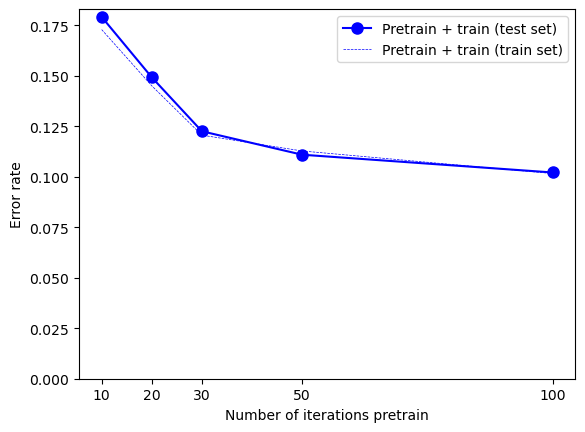

In [ ]:
plot_DNN(
    pretrain_iter_sizes, 
    acc_1_pretrain_iter, 
    # acc_2_pretrain_iter, 
    acc_1_train=acc_1_pretrain_iter_train, 
    # acc_2_train=acc_2_pretrain_iter_train, 
    x_label='Number of iterations pretrain', 
    # top=.1,
    save="mnist_number_of_pretrain_iter"
    )

## 4.6. Number of epochs for training

In [ ]:
acc_1_train_iter = []
acc_2_train_iter = []
acc_1_train_iter_train = []
acc_2_train_iter_train = []

n_layers = [784] + [2 * n_main] * n_hidden +  [10]

if notebook_version=='light':
    train_iter_sizes = [20, 50, 100, 200]
if notebook_version=='full':
    train_iter_sizes = [20, 50, 100, 200, 300, 500, 700, 1000] # ------------------------------------------


for train_iter_ in train_iter_sizes:
    print(f"--- {train_iter_} iterations in DNN train ---")

    """-------------- Model 1 : pre-train + train -------------------"""
    ce_model1, score_model1, train_score_model1, _ = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter,
        train_iter=train_iter_,
        verbose=1,
    )
    acc_1_train_iter.append(score_model1)
    acc_1_train_iter_train.append(train_score_model1)

    """-------------- Model 2 : train only ---------------------------"""
    ce_model2, score_model2, train_score_model2, _ = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter_,
        verbose=1,
    )
    acc_2_train_iter.append(score_model2)
    acc_2_train_iter_train.append(train_score_model2)

--- 20 iterations in DNN train ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


Entrainement du DNN...


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


accuracy_score (train) 0.8060833333333334
accuracy_score (test) 0.7976
Entrainement du DNN...


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


accuracy_score (train) 0.2609166666666667
accuracy_score (test) 0.2526
--- 50 iterations in DNN train ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Entrainement du DNN...


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


accuracy_score (train) 0.8510833333333333
accuracy_score (test) 0.844
Entrainement du DNN...


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


accuracy_score (train) 0.6548333333333334
accuracy_score (test) 0.6538
--- 100 iterations in DNN train ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Entrainement du DNN...


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


accuracy_score (train) 0.8991666666666667
accuracy_score (test) 0.8893
Entrainement du DNN...


100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


accuracy_score (train) 0.855
accuracy_score (test) 0.8416
--- 200 iterations in DNN train ---
Pré-entrainement du DNN...
Entrainement du RBM...


100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


Entrainement du RBM...


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


Entrainement du DNN...


100%|██████████| 200/200 [00:55<00:00,  3.59it/s]


accuracy_score (train) 0.9375833333333333
accuracy_score (test) 0.9193
Entrainement du DNN...


100%|██████████| 200/200 [00:53<00:00,  3.71it/s]


accuracy_score (train) 0.9189166666666667
accuracy_score (test) 0.8972


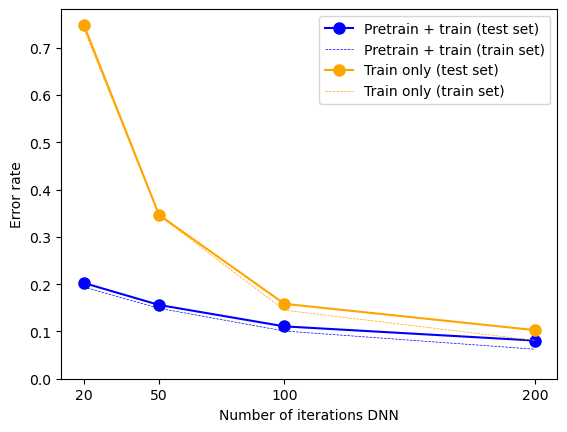

In [ ]:
plot_DNN(
    train_iter_sizes, 
    acc_1_train_iter, 
    acc_2_train_iter, 
    acc_1_train=acc_1_train_iter_train, 
    acc_2_train=acc_2_train_iter_train, 
    x_label='Number of iterations DNN', 
    save="mnist_number_of_train_iter"
    )

In [128]:
n_main, n_hidden, pretrain_iter, train_iter

(50, 2, 10, 30)

## 4.6. Best set of parameters and results


In [129]:
# """-------------- Model 1 : pre-train + train -------------------"""

# if notebook_version=='full':
#     X_train_f, X_test, y_train_f, y_test = lire_mnist(subsample_size=-1)
#     n_layers_b = [784, 700, 700, 10]
#     pretrain_iter_b = 50
#     train_iter_b = 500
#     batch_size_b = 64

#     ce_model1, score_model1, train_score_model1, model1 = DNN_main(
#         X_train_f,
#         X_test,
#         y_train_f,
#         y_test,
#         n_layers=n_layers_b,
#         lr=lr,
#         batch_size=batch_size_b,
#         pretrain_iter=pretrain_iter_b,
#         train_iter=train_iter_b,
#         verbose=1,
#     )

#     print("----------  Resultat model 1 : pré-entraînément + entraînément  --------- ")
#     print("            cross_entropie : ", ce_model1)
#     print("            Accuracy : ", score_model1)
#     print("       ")


In [130]:
# if notebook_version=='full':
#   # ----------
#   train_size_b = 60000 # 
#   n_main_b = 700 # 
#   n_hidden_b = 2 # 
#   pretrain_iter = pretrain_iter_b # 
#   train_iter = train_iter_b # 

#   # Create directory to save plots
#   savepath_b = 'save' + '_' + str(train_size_b) + '_' + str(n_main_b) + '_' + str(n_hidden_b) + '_' + str(pretrain_iter_b) +'_' + str(train_iter_b) + '/'
#   if not os.path.exists(savepath):
#       os.makedirs(savepath)
#       print('Directory "' + str(savepath) + '" created')
#   import pickle
#   with open(savepath_b + 'best_model_pretrain.pkl', 'wb') as f:
#     pickle.dump(model1, f)


In [131]:

# with open(savepath_b + 'best_model_pretrain.pkl', 'rb') as f:
#   model1_ = pickle.load(f)


In [132]:


# """-------------- Model 2 : train only ---------------------------"""

# X_train_f, X_test, y_train_f, y_test = lire_mnist(subsample_size=-1)
# n_layers_b2 = [784, 100, 100, 10]
# train_iter_b = 100
# batch_size_b = 256
# pretrain_iter = False
# ce_model2, score_model2, train_score_model2, model2 = DNN_main(
#     X_train_f,
#     X_test,
#     y_train_f,
#     y_test,
#     n_layers=n_layers_b2,
#     lr=lr,
#     batch_size=batch_size_b,
#     pretrain_iter=pretrain_iter,
#     train_iter=train_iter_b,
#     verbose=1,
# )

# print("----------  Resultat model 2 : uniquement entrainé  --------- ")
# print("            cross_entropie : ", ce_model2)
# print("            Accuracy : ", score_model2)

In [133]:
X_ = X_test
y_ = y_test
# X_ = X_train_f
# y_ = y_train_f
y_pred, _ = model1_.test(X_, y_)
test_score = accuracy_score(np.argmax(y_, axis=1), np.argmax(y_pred, axis=1))
print(test_score)
plot_preds(X_, y_, y_pred, save=False)

NameError: name 'model1_' is not defined

0.9842


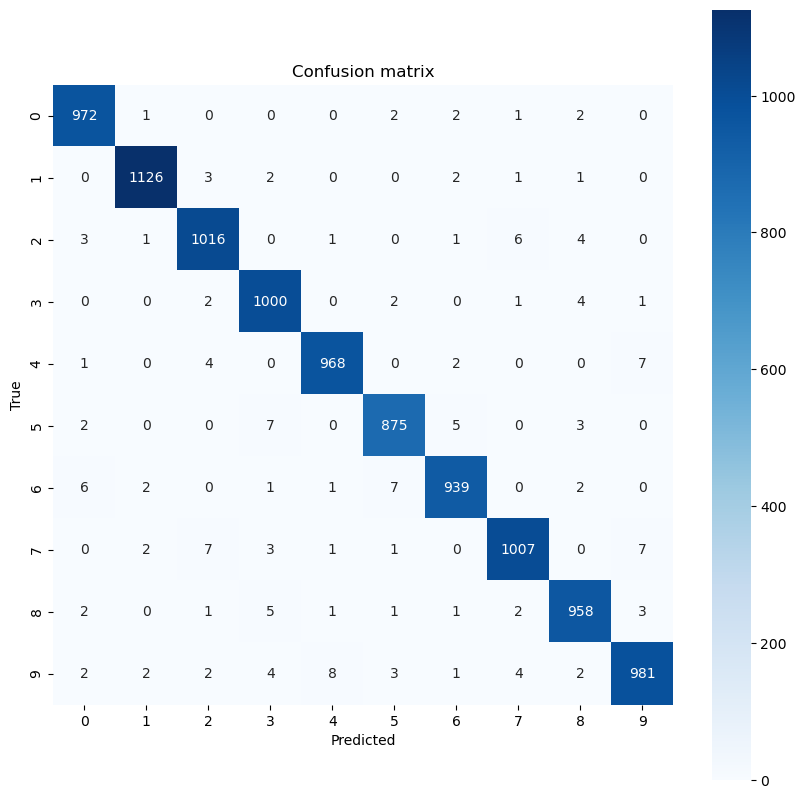

In [38]:
savepath_b = 'save/'
with open(savepath_b + 'best_model_pretrain.pickle', 'rb') as f:
    model = pickle.load(f)

X_ = X_test
y_ = y_test
y_pred, _ = model.test(X_, y_)
test_score = accuracy_score(np.argmax(y_, axis=1), np.argmax(y_pred, axis=1))
print(test_score)
plot_confusion_matrix(X_, y_, y_pred, save='best_model')

Le score obtenu avec le meilleur jeu de paramètres est de 98.5% sur le jeu de test.

Observons les résultats de ce modèle de plus près. Nous avons tracé la matrice de confusion ci-dessus. Le modèle classifie presque parfaitement chaque nombre. Il est cependant possible d'identifier quelques erreurs. Par exemple, le modèle confond souvent les 5 et 3 ; les 6 et 5 : les 7 et 2 ; les 4 et 9 ; les 7 et 9 ; et les 9 et 4. Ces erreurs sont compréhensibles car ces chiffres ont des formes similaires.

A l'inverse, certains chiffres sont très bien classifiés. Par exemple, le modèle fait très peu d'erreurs pour les 0 et 1.

# 5. VAE (Variational Auto-Encoder)

In [ ]:
# X_train, X_test, y_train, y_test = lire_mnist(subsample_size=-1)

In [ ]:
# class VAE(nn.Module):
#     def __init__(self, input_dim, hidden_dim, latent_dim):
#         super(VAE, self).__init__()

#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.latent_dim = latent_dim

#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc21 = nn.Linear(hidden_dim, latent_dim)
#         self.fc22 = nn.Linear(hidden_dim, latent_dim)
#         self.fc3 = nn.Linear(latent_dim, hidden_dim)
#         self.fc4 = nn.Linear(hidden_dim, input_dim)

#     def encode(self, x):
#         h1 = F.relu(self.fc1(x))
#         return self.fc21(h1), self.fc22(h1)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return eps.mul(std).add_(mu)

#     def decode(self, z):
#         h3 = F.relu(self.fc3(z))
#         return torch.sigmoid(self.fc4(h3))

#     def forward(self, x):
#         mu, logvar = self.encode(x.view(-1, self.input_dim))
#         z = self.reparameterize(mu, logvar)
#         return self.decode(z), mu, logvar

In [ ]:
# def loss_function(recon_x, x, mu, logvar):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")

#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#     return BCE + KLD

In [ ]:
# def train(model, device, train_loader, optimizer, epoch, verbose=1):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):
#         data = data.to(device)
#         optimizer.zero_grad()
#         recon_batch, mu, logvar = model(data)
#         loss = loss_function(recon_batch, data, mu, logvar)
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
#         if batch_idx % 100 == 0 and verbose >= 2:
#             print(
#                 "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
#                     epoch,
#                     batch_idx * len(data),
#                     len(train_loader.dataset),
#                     100.0 * batch_idx / len(train_loader),
#                     loss.item() / len(data),
#                 )
#             )
#     if verbose >= 1:
#         print(
#             "====> Epoch: {} Average loss: {:.4f}".format(
#                 epoch, train_loss / len(train_loader.dataset)
#             )
#         )


# def test(model, device, test_loader, verbose=1):
#     model.eval()
#     test_loss = 0
#     with torch.no_grad():
#         for i, (data, _) in enumerate(test_loader):
#             data = data.to(device)
#             recon_batch, mu, logvar = model(data)
#             test_loss += loss_function(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat(
#                     [data[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]]
#                 )
#                 save_image(
#                     comparison.cpu(),
#                     "reconstruction.png",
#                     nrow=n,
#                 )

#     test_loss /= len(test_loader.dataset)
#     if verbose >= 1:
#         print("====> Test set loss: {:.4f}".format(test_loss))


# def VAE_main(train_loader, test_loader, batch_size, epochs, lr):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     kwargs = {"num_workers": 1, "pin_memory": True} if torch.cuda.is_available() else {}

#     model = VAE(784, 400, 20).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     for epoch in tqdm(range(1, epochs + 1)):
#         train(model, device, train_loader, optimizer, epoch)
#         test(model, device, test_loader)
#         with torch.no_grad():
#             sample = torch.randn(25, 20).to(device)
#             sample = model.decode(sample).cpu()
#             save_image(
#                 sample.view(25, 1, 28, 28),
#                 "sample_" + str(epoch) + ".png",
#             )

In [ ]:
# mnist_train = datasets.MNIST(
#     "data/", train=True, download=True, transform=transforms.ToTensor()
# )
# mnist_test = datasets.MNIST(
#     "data/", train=False, download=True, transform=transforms.ToTensor()
# )
# train_loader = torch.utils.data.DataLoader(
#     mnist_train,
#     batch_size=batch_size,
#     shuffle=True,
# )
# test_loader = torch.utils.data.DataLoader(
#     mnist_test,
#     batch_size=batch_size,
#     shuffle=True,
# )

# VAE_main(train_loader, test_loader, batch_size=128, epochs=10, lr=1e-3)